In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.orm import create_session
from sqlalchemy.ext.automap import automap_base
from datetime import datetime
from datetime import timedelta
from sqlalchemy.sql.expression import func
import matplotlib.pyplot as plt
import numpy as np

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

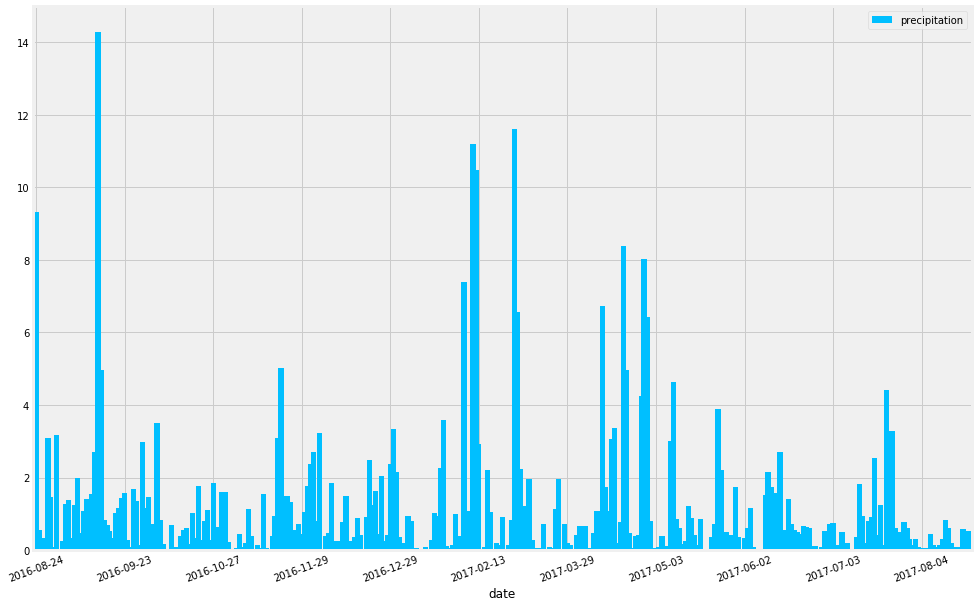

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(measurement.date)).one()
max_date= datetime.strptime(max_date[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
m_Data = session.query(measurement.date, func.sum(measurement.prcp).label('precipitation'))\
.filter(measurement.date >= (max_date - timedelta(days=365))).filter(measurement.prcp >0).group_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_measurement = pd.DataFrame(m_Data)
df_measurement = df_measurement.set_index("date")
# Sort the dataframe by date
df_measurement = df_measurement.sort_values(by=["date"])
# Use Pandas Plotting with Matplotlib to plot the data
df_measurement = df_measurement.reset_index()
ax = df_measurement.plot.bar(y="precipitation",x="date" , figsize=(15,10), width= 1.8,color="deepskyblue")
ax.set_xticks(df_measurement.index[::30])
ax.set_xticklabels(df_measurement.date[::30], rotation =20)
plt.show()
fig = ax.get_figure()
fig.savefig("precipitation")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_full = session.query(measurement.id,measurement.station,measurement.date, measurement.prcp,measurement.tobs).all()
df_measure = pd.DataFrame(measure_full)
df_measure["prcp"].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [14]:
# Design a query to show how many stations are available in this dataset?
df_measure["station"].nunique()


9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_station = df_measure[["station","id"]].groupby("station").count().sort_values(by="id", ascending=False).rename(columns={"id":"Total Count"})
df_station

,Total Count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
df_active_station = df_measure[["station","tobs"]].loc[df_measure["station"]==df_station.index[0]].describe()
df_active_station.loc[["min","max","mean"]]


,tobs
min,54.000000
max,85.000000
mean,71.663781


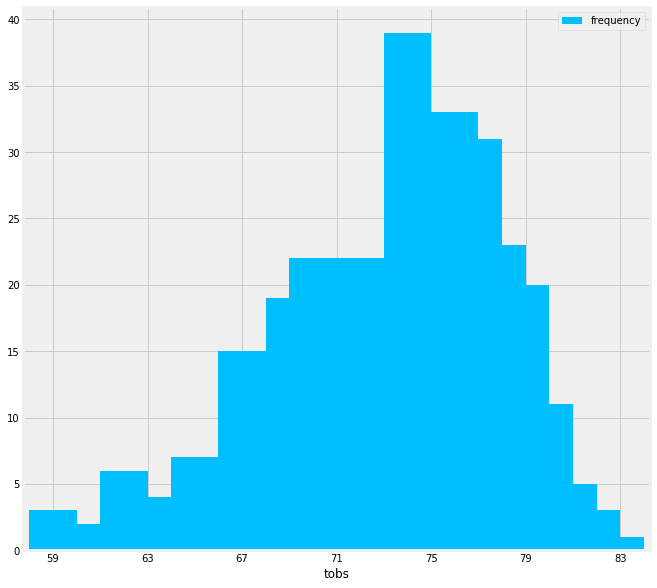

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

max_date_temp = session.query(func.max(measurement.date)).filter(measurement.station==df_station.index[0]).one()
max_date_temp = datetime.strptime(max_date_temp[0], '%Y-%m-%d')

m_temp = session.query(measurement.tobs, func.count(measurement.tobs).label('frequency'))\
.filter(measurement.date >= (max_date_temp - timedelta(days=365))).filter(measurement.station==df_station.index[0] ).group_by(measurement.tobs).all()
df_temp_data = pd.DataFrame(m_temp)
df_temp_data["tobs"] = df_temp_data["tobs"].astype("int64")

ax = df_temp_data.plot.bar(x="tobs",y="frequency",figsize=(10,10),width=2,color="deepskyblue")
ax.set_xticks(df_temp_data.index[::4])
ax.set_xticklabels(df_temp_data.tobs[::4], rotation =0)
plt.show()

fig = ax.get_figure()
fig.savefig("tobs")


In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_data = calc_temps('2016-02-28', '2016-03-05')
print(temp_data)

[(62.0, 69.88636363636364, 80.0)]


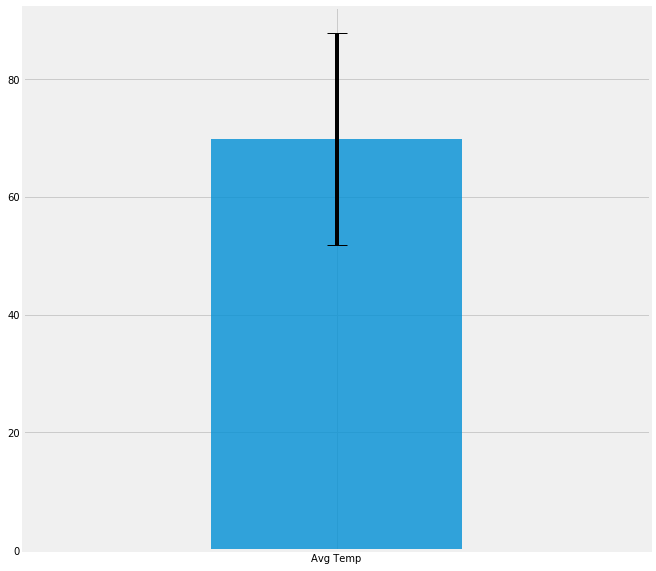

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
height = [temp_data[0][1]]
x = np.arange(len(height))
error = [temp_data[0][2] -temp_data[0][0]]
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x=x, height = height, yerr = error , align ="center", alpha=0.8, capsize=10)
ax.set_xticks(x)
ax.set_xticklabels(["Avg Temp"])
ax.set_xlim(-1,1)

fig = ax.get_figure()
fig.savefig("avg_temp")
plt.show()

In [22]:
q_station = session.query(station.station,station.name,station.longitude, station.latitude, station.elevation).all()
df_station = pd.DataFrame(q_station)

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
measure_grp = session.query(measurement.station, func.sum(measurement.prcp).label("prcp"))\
.filter(measurement.date >='2016-02-28').filter(measurement.date <='2016-03-05').group_by(measurement.station).all()
df_measure_grp= pd.DataFrame(measure_grp)
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
df_summary = df_station.join(df_measure_grp.set_index("station"), on="station").sort_values(by="prcp", ascending=False)
df_summary.head()


,station,name,longitude,latitude,elevation,prcp
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",-157.71139,21.33556,19.5,0.33
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",-157.83740,21.52130,7.0,0.12
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",-157.80250,21.33310,152.4,0.02
6,USC00519281,"WAIHEE 837.5, HI US",-157.84889,21.45167,32.9,0.01
0,USC00519397,"WAIKIKI 717.2, HI US",-157.81680,21.27160,3.0,0.00


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
measure_grp = session.query(measurement.date)\
.filter(measurement.date >='2016-02-28').filter(measurement.date <='2016-03-05').group_by(measurement.date).all()
df_date_range = pd.DataFrame(measure_grp)
# Stip off the year and save a list of %m-%d strings

normals=[]
#Loop through the list of %m-%d strings and calculate the normals for each date
for dat in df_date_range["date"]:
    normals.append(daily_normals(datetime.strptime(dat,'%Y-%m-%d').strftime('%m-%d'))[0])

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals, columns=["Min","Avg","Max"], index=df_date_range["date"])
df_normals

,Min,Avg,Max
date,,,
2016-02-28,65.0,70.655172,80.0
2016-02-29,67.0,71.733333,79.0
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0


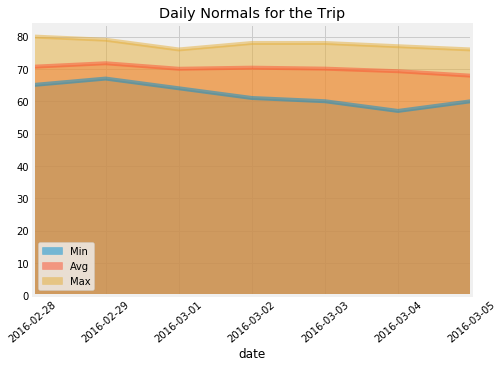

In [27]:
# Plot the daily normals as an area plot with `stacked=False`

ax = df_normals.plot.area(use_index=True, figsize=(7,5),stacked=False,alpha=0.5)
ax.set_xticks(np.arange(len(df_normals)))
ax.set_xticklabels(df_normals.index, rotation=40)
ax.set_title("Daily Normals for the Trip")
fig = ax.get_figure()
fig.savefig("norms")
plt.show()